In [3]:
target = 0

fill out missing empty files where no target detected for predictions

In [4]:
predictions_path = f'./runs/detect/SIGGI_{target}/labels'
ground_truth_path = f'./../datasets/SIGGI/targets/{target}/labels/val'

In [12]:
import os

all_preds = [f for f in os.listdir(predictions_path) if f.endswith('.txt')]
all_gr_truths = [f for f in os.listdir(ground_truth_path) if f.endswith('.txt')]

print(len(set(all_preds)))
print(len(set(all_gr_truths)))

62
120


In [16]:
only_in_gr_truth = set(all_gr_truths) - set(all_preds)
len(only_in_gr_truth)

58

In [17]:
for missing_file in only_in_gr_truth:
    open(os.path.join(predictions_path, missing_file), 'w').close()

In [19]:
all_preds = [f for f in os.listdir(predictions_path) if f.endswith('.txt')]
len(set(all_preds))

120

In [20]:
if all_preds == all_gr_truths:
    print("Files match.")
else:
    print("Files do not match.")

Files match.


now calculate IoUs and GIoUs

In [31]:
def read_yolo_format(file_path):
    boxes = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 5 or len(parts) == 6:  # class, x_center, y_center, width, height [+ confidence]
                if len(parts) == 5:
                    _, x_center, y_center, width, height = map(float, parts)
                    confidence = None
                elif len(parts) == 6:
                    _, x_center, y_center, width, height, confidence = map(float, parts)
                
                # Convert to [x1, y1, x2, y2] format
                x1 = x_center - width / 2
                y1 = y_center - height / 2
                x2 = x_center + width / 2
                y2 = y_center + height / 2
                
                boxes.append([x1, y1, x2, y2])
    return boxes

In [32]:
all_preds_paths = [os.path.join(predictions_path, f) for f in all_preds]
all_preds_paths.sort()
all_gr_truths_paths = [os.path.join(ground_truth_path, f) for f in all_gr_truths]
all_gr_truths_paths.sort()

In [35]:
!conda activate jupyterlab-debugger

usage: conda [-h] [-v] [--no-plugins] [-V] COMMAND ...
conda: error: argument COMMAND: invalid choice: 'activate' (choose from 'clean', 'compare', 'config', 'create', 'info', 'init', 'install', 'list', 'notices', 'package', 'remove', 'uninstall', 'rename', 'run', 'search', 'update', 'upgrade', 'doctor', 'env')


In [57]:
import torch
from torchvision.ops import box_iou, generalized_box_iou

iou_list = []
giou_list = []

for pred_file, gr_truth_file in zip(all_preds_paths, all_gr_truths_paths):
    predictions = read_yolo_format(pred_file)
    ground_truths = read_yolo_format(gr_truth_file)
    
    if predictions:
        predictions_tensor = torch.tensor(predictions)
    else:
        predictions_tensor = torch.empty((0, 4))   # Handle empty predictions case

    if ground_truths:
        ground_truth_tensor = torch.tensor(ground_truths)   
    else:
        ground_truth_tensor = torch.empty((0, 4))   # Handle empty ground truths case
        
    # for debugging
    predictions_list = predictions_tensor.tolist()
    ground_truth_list = ground_truth_tensor.tolist()

    for prediction in predictions_tensor:
        prediction = prediction.unsqueeze(0)
        iou = box_iou(prediction, ground_truth_tensor)
        giou = generalized_box_iou(prediction, ground_truth_tensor)
        iou_list.extend(iou.numpy().flatten().tolist())
        giou_list.extend(giou.numpy().flatten().tolist())

In [130]:
iou_list

[0.9242565035820007,
 0.892663836479187,
 0.7454383969306946,
 0.8426376581192017,
 0.9508058428764343,
 0.8685008883476257,
 0.5790491104125977,
 0.9539273977279663,
 0.9028513431549072,
 0.9137369990348816,
 0.9099195003509521,
 0.6978510022163391,
 0.7932738065719604,
 0.46474069356918335,
 0.7102133631706238,
 0.9395812153816223,
 0.9433336853981018,
 0.7278780341148376,
 0.878048300743103,
 0.9678182005882263,
 0.9295474886894226,
 0.9631004929542542,
 0.9344300031661987,
 0.929855227470398,
 0.9149542450904846,
 0.9745522737503052,
 0.9724975228309631,
 0.9030038118362427,
 0.970917820930481,
 0.8488744497299194,
 0.9858248829841614,
 0.9501160383224487,
 0.9820380210876465,
 0.9687333106994629,
 0.9457850456237793,
 0.9450052380561829,
 0.9819778800010681,
 0.9789494872093201,
 0.9080080389976501,
 0.9736151695251465,
 0.7596917152404785,
 0.7178624272346497,
 0.908385694026947,
 0.9041147232055664,
 0.7855697870254517,
 0.8617674112319946,
 0.9011812806129456,
 0.95562684535980

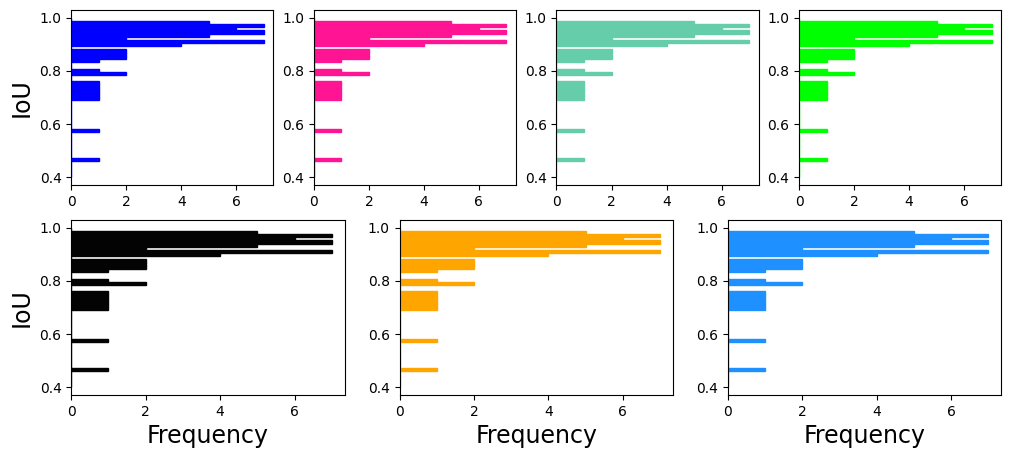

In [129]:
data_lists = [iou_list,iou_list,iou_list,iou_list,iou_list,iou_list,iou_list]
titles = ['SIGGI_0', 'SIGGI_1', 'SIGGI_2', 'SIGGI_3', 'SIGGI_4', 'SIGGI_5', 'SIGGI_6']
colors = ['#0000FF', '#FF1493', '#66CDAA', '#00FF00', '#030303', '#FFA500', '#1E90FF']

num_histograms = len(data_lists)
# num_columns = 7
num_columns_first_row = 4
num_columns_second_row = 3

plt.figure(figsize=(12,5))
f=17

for i in range(num_columns_first_row):
    plt.subplot(2, num_columns_first_row, i+1)
    plt.hist(data_lists[i], bins=50, range=(0.4, 1), alpha=1, color=colors[i], edgecolor=colors[i], orientation='horizontal')
    # plt.title(titles[i], color=colors[i])
    # plt.xlabel('Frequency')
    if i==0:
        plt.ylabel('IoU', fontsize=f)
    
for i in range(num_columns_second_row):
    plt.subplot(2, num_columns_second_row, num_columns_first_row+i)
    plt.hist(data_lists[num_columns_first_row+i], bins=50, range=(0.4, 1), alpha=1, color=colors[num_columns_first_row+i], edgecolor=colors[num_columns_first_row+i], orientation='horizontal')
    # plt.title(titles[num_columns_first_row+i], color=colors[num_columns_first_row+i])
    plt.xlabel('Frequency', fontsize=f)
    if i==0:
        plt.ylabel('IoU', fontsize=f)

plt.show()